In [ ]:
# Import the libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from xgboost import XGBRegressor # Corrected import
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

import seaborn as sns    # plot tools

# Take a look in the Stocks directory to select one dataset from a company

import os

In [ ]:
# 1. Mount Google Drive (hanya perlu sekali per sesi)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/data/sahamsent_baru.csv'
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Cek struktur
print(df.info())
print(df.describe())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           797 non-null    datetime64[ns]
 1   Ticker         797 non-null    object        
 2   Open           797 non-null    float64       
 3   High           797 non-null    float64       
 4   Low            797 non-null    float64       
 5   Close          797 non-null    float64       
 6   Volume         797 non-null    float64       
 7   total_tweet    797 non-null    int64         
 8   positif_tweet  797 non-null    int64         
 9   negatif_tweet  797 non-null    int64         
 10  netral_tweet   797 non-null    int64         
 11  avg_compound   797 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 74.8+ KB
None
                                Date         Open         High          Low  \
count          

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Year'] = df['Date'].dt.year

In [ ]:
stock_names = df["Ticker"].unique()

num_stock_names = len(stock_names)
print(f"Jumlah jenis stock name: {num_stock_names}")

print("Daftar stock name:")
print(stock_names)

Jumlah jenis stock name: 3
Daftar stock name:
['TINS.JK' 'ISAT.JK' 'MDKA.JK']


In [ ]:
stock_counts = df["Ticker"].value_counts()
stock_counts

,count
Ticker,
MDKA.JK,328
ISAT.JK,256
TINS.JK,213


In [ ]:
# Tambahkan kolom 'Month' dan 'Year' untuk gruping
df['YearMonth'] = df['Date'].dt.to_period('M')

In [ ]:
# Tambahkan kolom YearMonth
df['YearMonth'] = df['Date'].dt.to_period('M')

# Ambil data awal dan akhir per bulan secara manual
first_close = df.sort_values('Date').groupby('YearMonth')['Close'].first()
last_close = df.sort_values('Date').groupby('YearMonth')['Close'].last()

# Hitung aggregasi lainnya
monthly_agg = df.groupby('YearMonth').agg({
    'positif_tweet': 'sum',
    'negatif_tweet': 'sum',
    'avg_compound': 'mean'
}).reset_index()

# Gabungkan semua hasil ke dataframe akhir
monthly_agg['Harga_Awal'] = first_close.values
monthly_agg['Harga_Akhir'] = last_close.values
monthly_agg['Kenaikan_Harga_%'] = ((monthly_agg['Harga_Akhir'] - monthly_agg['Harga_Awal']) / monthly_agg['Harga_Awal'])

# Urutkan kolom agar lebih rapi
monthly_analysis = monthly_agg[[
    'YearMonth', 'Harga_Awal', 'Harga_Akhir', 'Kenaikan_Harga_%',
    'positif_tweet', 'negatif_tweet', 'avg_compound'
]].rename(columns={
    'positif_tweet': 'Sentimen_Positif',
    'negatif_tweet': 'Sentimen_Negatif',
    'avg_compound': 'Rata2_Compound'
})
display(monthly_analysis)

,YearMonth,Harga_Awal,Harga_Akhir,Kenaikan_Harga_%,Sentimen_Positif,Sentimen_Negatif,Rata2_Compound
0,2019-01,347.079747,858.398613,1.473203,0,0,0.000000
1,2019-02,723.519659,786.434462,0.086957,3,0,0.169862
2,2019-04,488.637953,488.637953,0.000000,0,0,0.000000
3,2019-05,416.286010,370.148501,-0.110831,1,0,0.386950
4,2019-06,503.318087,503.318087,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...
72,2025-02,2220.000000,1045.000000,-0.529279,17,6,0.114783
73,2025-03,1480.000000,905.000000,-0.388514,9,5,0.176880
74,2025-05,1814.579956,2020.000000,0.113205,19,4,0.280564
75,2025-06,1060.116455,2000.000000,0.886585,33,10,0.229172


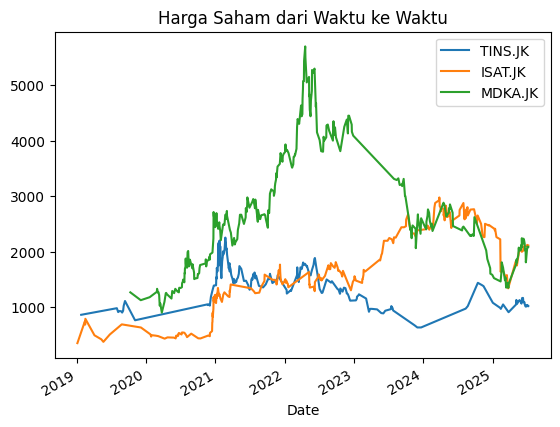

In [ ]:
# Plot harga
for ticker in df['Ticker'].unique():
    df[df['Ticker'] == ticker].set_index('Date')['Close'].plot(label=ticker)
plt.legend()
plt.title("Harga Saham dari Waktu ke Waktu")
plt.show()

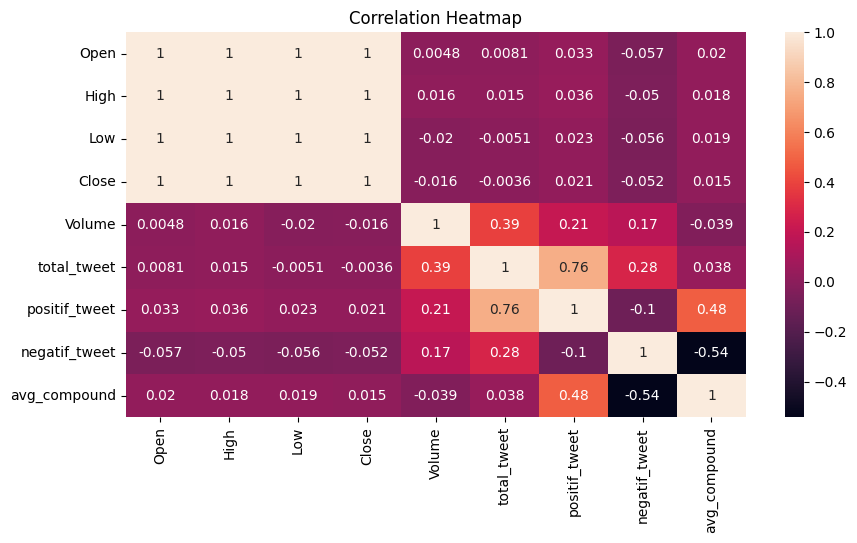

In [ ]:
# 5. EDA
plt.figure(figsize=(10,5))
sns.heatmap(df[['Open','High','Low','Close','Volume','total_tweet','positif_tweet','negatif_tweet','avg_compound']].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
import pandas as pd

df_tins_filtered = df[
    (df['Ticker'] == 'ISAT.JK') &
    (df['Date'] >= pd.Timestamp('2025-02-01')) &
    (df['Date'] <= pd.Timestamp('2025-03-31'))
][['Date', 'Close', 'negatif_tweet']]
# Tampilkan 10 baris pertama
print(df_tins_filtered.head(10))

          Date   Close  negatif_tweet
448 2025-02-10  2220.0              2
449 2025-02-11  1920.0              1
450 2025-02-12  1635.0              0
451 2025-02-20  1700.0              0
452 2025-03-12  1515.0              0
453 2025-03-13  1545.0              1
454 2025-03-17  1575.0              0
455 2025-03-21  1415.0              0
456 2025-03-24  1335.0              0


<Figure size 1800x500 with 0 Axes>

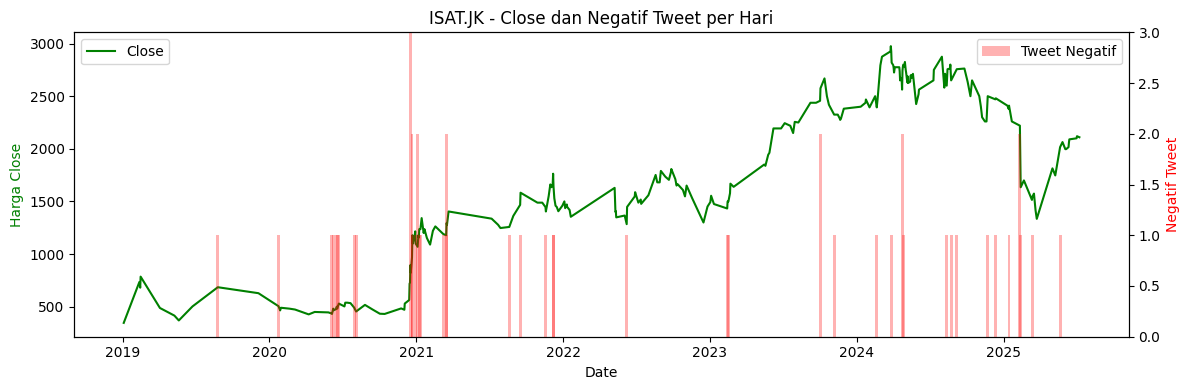

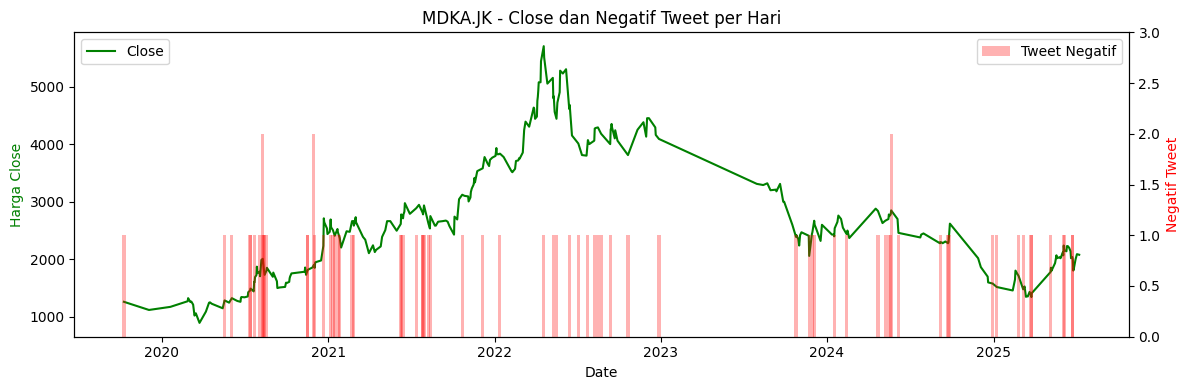

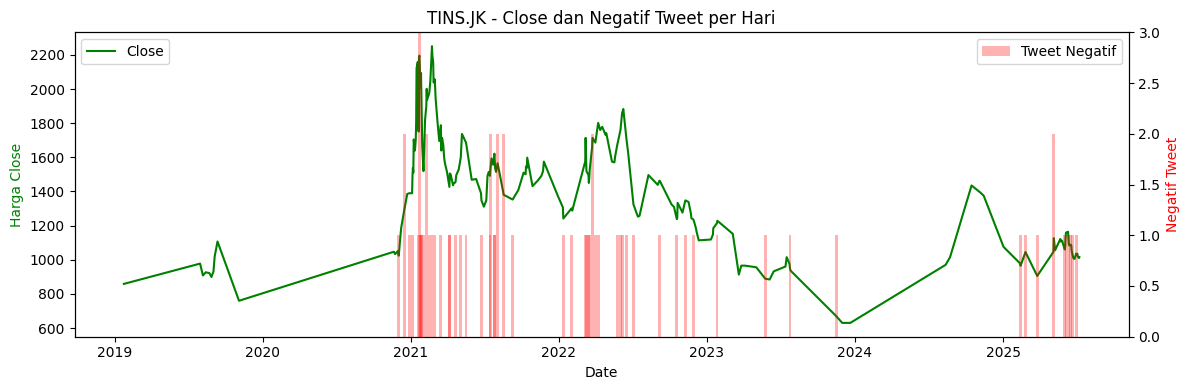

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asumsikan df adalah DataFrame yang sudah berisi semua data
tickers = ['ISAT.JK', 'MDKA.JK', 'TINS.JK']

plt.figure(figsize=(18, 5))

for ticker in tickers:
    subset = df[df['Ticker'] == ticker].sort_values('Date')
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2 = ax1.twinx()

    ax1.plot(subset['Date'], subset['Close'], 'g-', label='Close')
    ax2.bar(subset['Date'], subset['negatif_tweet'], width=7, alpha=0.3, color='red', label='Tweet Negatif')
    ax2.set_ylim(0, 3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Harga Close', color='g')
    ax2.set_ylabel('Negatif Tweet', color='r')
    plt.title(f'{ticker} - Close dan Negatif Tweet per Hari')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# ISAT.JK dari 2022 sampai 2025
df_isat = df[(df['Ticker'] == 'ISAT.JK') &
             (df['Date'] >= '2025-01-01') &
             (df['Date'] <= '2025-03-21')]

# MDKA.JK dari 2020 sampai 2023
df_mdka = df[(df['Ticker'] == 'MDKA.JK') &
             (df['Date'] >= '2024-05-01') &
             (df['Date'] <= '2024-08-21')]

# TINS.JK dari 2021 sampai 2024
df_tins = df[(df['Ticker'] == 'TINS.JK') &
             (df['Date'] >= '2022-10-01') &
             (df['Date'] <= '2023-01-20')]


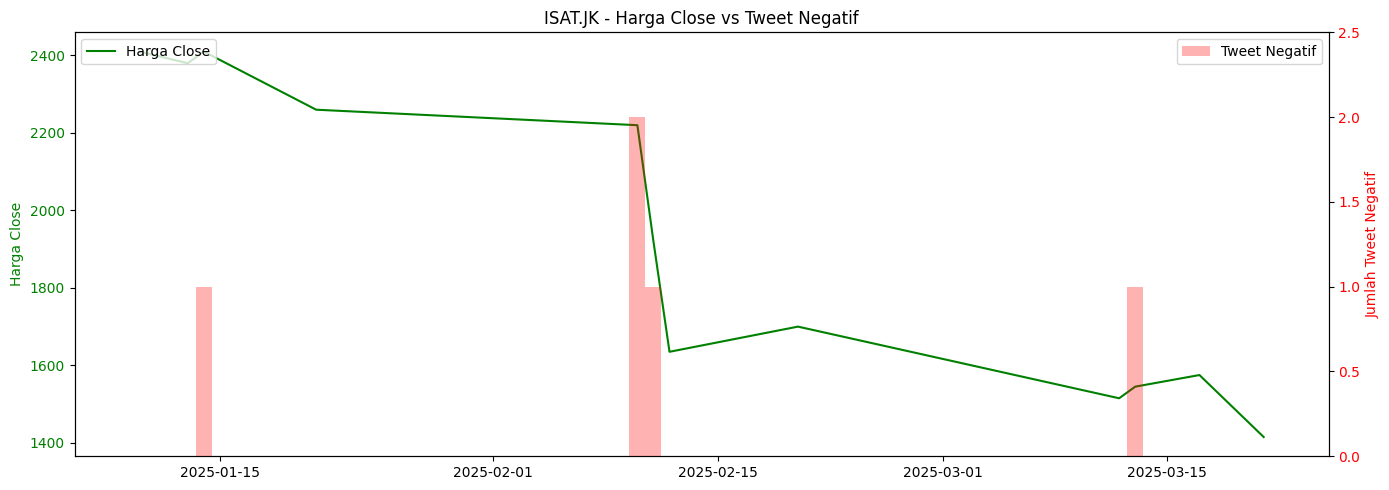

In [ ]:
subset = df_isat  # atau df_mdka, df_tins

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(subset['Date'], subset['Close'], 'g-', label='Harga Close')
ax1.set_ylabel('Harga Close', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.bar(subset['Date'], subset['negatif_tweet'], width=1, alpha=0.3, color='red',label='Tweet Negatif')
ax2.set_ylabel('Jumlah Tweet Negatif', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 2.5)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f"{subset['Ticker'].iloc[0]} - Harga Close vs Tweet Negatif")
plt.xlabel("Tanggal")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df_tins_filtered = df[
    (df['Ticker'] == 'ISAT.JK') &
    (df['Date'] >= pd.Timestamp('2025-02-01')) &
    (df['Date'] <= pd.Timestamp('2025-03-31'))
][['Date', 'Close', 'negatif_tweet']]
# Tampilkan 10 baris pertama
print(df_tins_filtered.head(10))

          Date   Close  negatif_tweet
448 2025-02-10  2220.0              2
449 2025-02-11  1920.0              1
450 2025-02-12  1635.0              0
451 2025-02-20  1700.0              0
452 2025-03-12  1515.0              0
453 2025-03-13  1545.0              1
454 2025-03-17  1575.0              0
455 2025-03-21  1415.0              0
456 2025-03-24  1335.0              0


In [ ]:
corr = df[df['Ticker'] == 'ISAT.JK']['Close'].corr(df['negatif_tweet'])
print(f"Korelasi ISAT.JK: {corr:.2f}")


Korelasi ISAT.JK: -0.09


In [ ]:
corr = df[df['Ticker'] == 'ISAT.JK']['Close'].corr(df['positif_tweet'])
print(f"Korelasi ISAT.JK: {corr:.2f}")


Korelasi ISAT.JK: -0.21


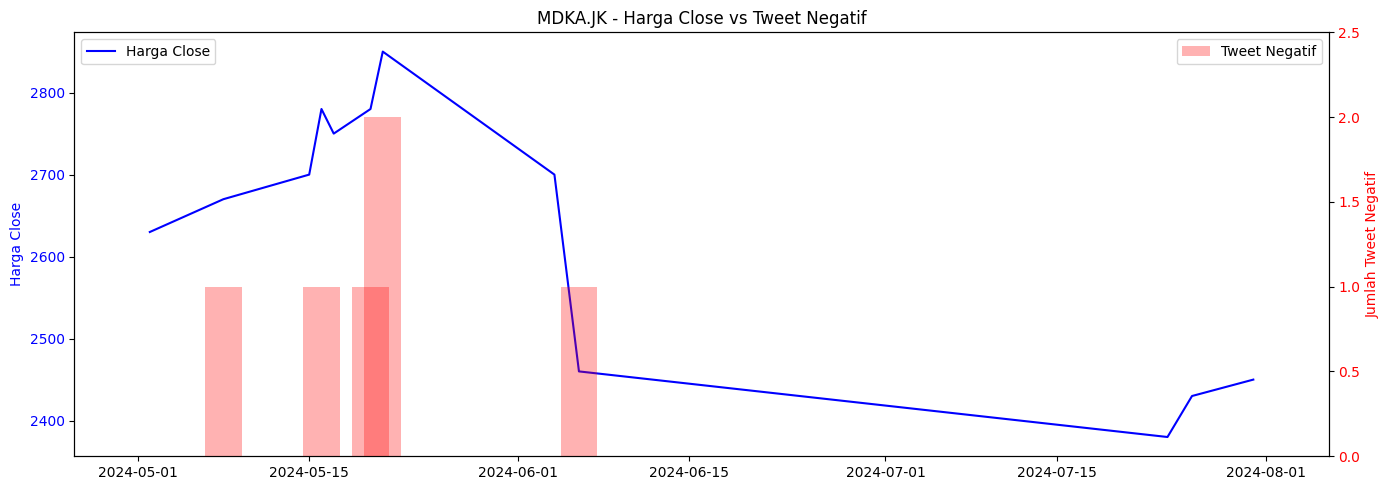

In [ ]:
subset = df_mdka  # atau df_mdka, df_tins

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(subset['Date'], subset['Close'], 'b-', label='Harga Close')
ax1.set_ylabel('Harga Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.bar(subset['Date'], subset['negatif_tweet'], width=3, alpha=0.3, color='red',label='Tweet Negatif')
ax2.set_ylabel('Jumlah Tweet Negatif', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 2.5)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f"{subset['Ticker'].iloc[0]} - Harga Close vs Tweet Negatif")
plt.xlabel("Tanggal")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df_tins_filtered = df[
    (df['Ticker'] == 'MDKA.JK') &
    (df['Date'] >= pd.Timestamp('2024-05-16')) &
    (df['Date'] <= pd.Timestamp('2024-06-11'))
][['Date', 'Close', 'negatif_tweet']]
# Tampilkan 10 baris pertama
print(df_tins_filtered.head(10))

          Date   Close  negatif_tweet
734 2024-05-16  2780.0              1
735 2024-05-17  2750.0              0
736 2024-05-20  2780.0              1
737 2024-05-21  2850.0              2
738 2024-06-04  2700.0              0
739 2024-06-06  2460.0              1


In [ ]:
corr = df[df['Ticker'] == 'MDKA.JK']['Close'].corr(df['negatif_tweet'])
print(f"Korelasi MDKA.JK: {corr:.2f}")

Korelasi MDKA.JK: -0.06


In [ ]:
corr = df[df['Ticker'] == 'MDKA.JK']['Close'].corr(df['positif_tweet'])
print(f"Korelasi MDKA.JK: {corr:.2f}")


Korelasi MDKA.JK: 0.11


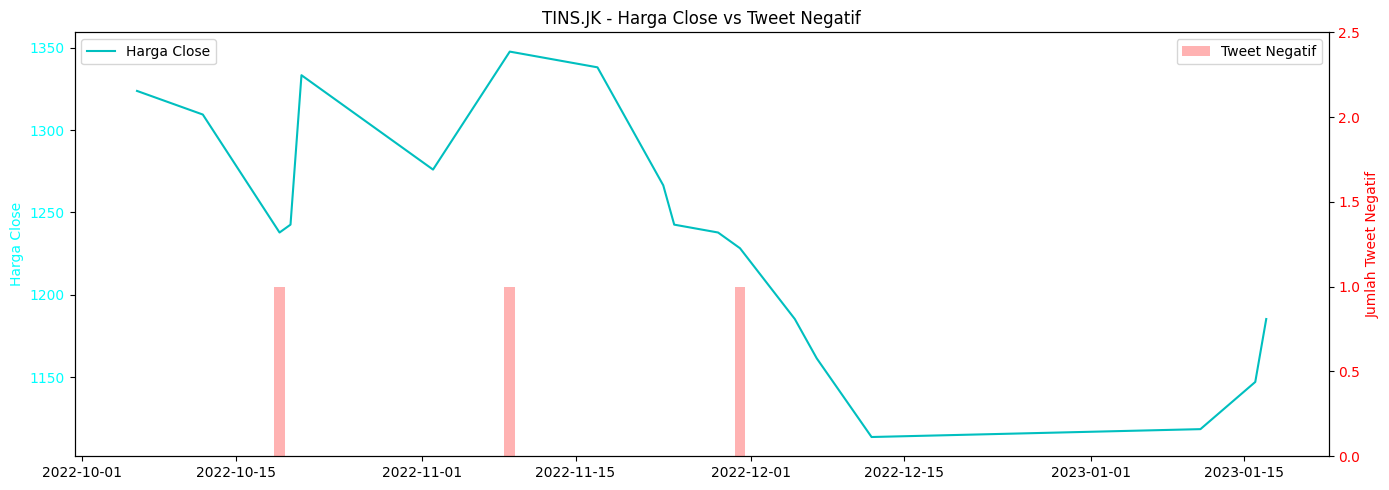

In [ ]:
subset = df_tins  # atau df_mdka, df_tins

fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.plot(subset['Date'], subset['Close'], 'c-', label='Harga Close')
ax1.set_ylabel('Harga Close', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan')

ax2 = ax1.twinx()
ax2.bar(subset['Date'], subset['negatif_tweet'], width=1, alpha=0.3, color='red',label='Tweet Negatif')
ax2.set_ylabel('Jumlah Tweet Negatif', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 2.5)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f"{subset['Ticker'].iloc[0]} - Harga Close vs Tweet Negatif")
plt.xlabel("Tanggal")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df_tins_filtered = df[
    (df['Ticker'] == 'TINS.JK') &
    (df['Date'] >= pd.Timestamp('2022-11-10')) &
    (df['Date'] <= pd.Timestamp('2022-12-10'))
][['Date', 'Close', 'negatif_tweet']]
# Tampilkan 10 baris pertama
print(df_tins_filtered.head(10))

          Date        Close  negatif_tweet
150 2022-11-17  1338.176527              0
151 2022-11-23  1266.488539              0
152 2022-11-24  1242.592584              0
153 2022-11-28  1237.813314              0
154 2022-11-30  1228.254968              1
155 2022-12-05  1185.242160              0
156 2022-12-07  1161.346041              0


In [ ]:
corr = df[df['Ticker'] == 'TINS.JK']['Close'].corr(df['negatif_tweet'])
print(f"Korelasi TINS.JK: {corr:.2f}")


Korelasi TINS.JK: 0.13


In [ ]:
corr = df[df['Ticker'] == 'TINS.JK']['Close'].corr(df['positif_tweet'])
print(f"Korelasi TINS.JK: {corr:.2f}")


Korelasi TINS.JK: 0.13


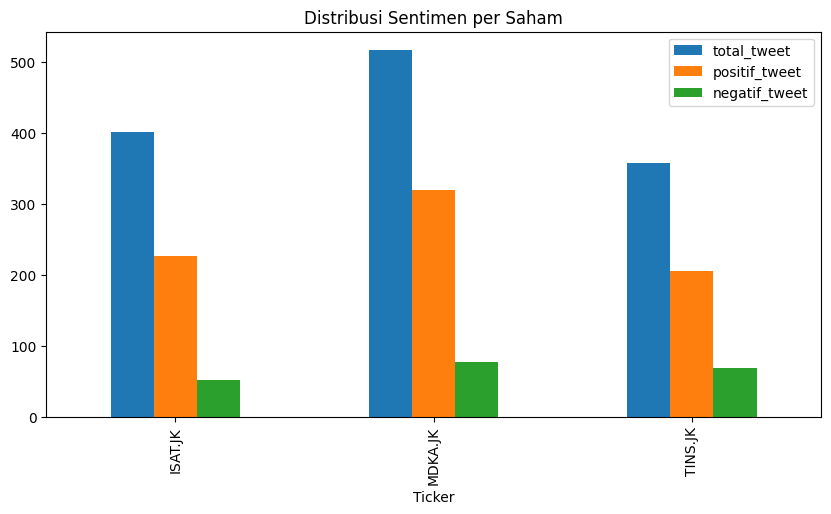

In [ ]:
# Distribusi sentimen
df.groupby(['Ticker'])[['total_tweet','positif_tweet','negatif_tweet']].sum().plot(kind='bar', figsize=(10,5))
plt.title("Distribusi Sentimen per Saham")
plt.show()


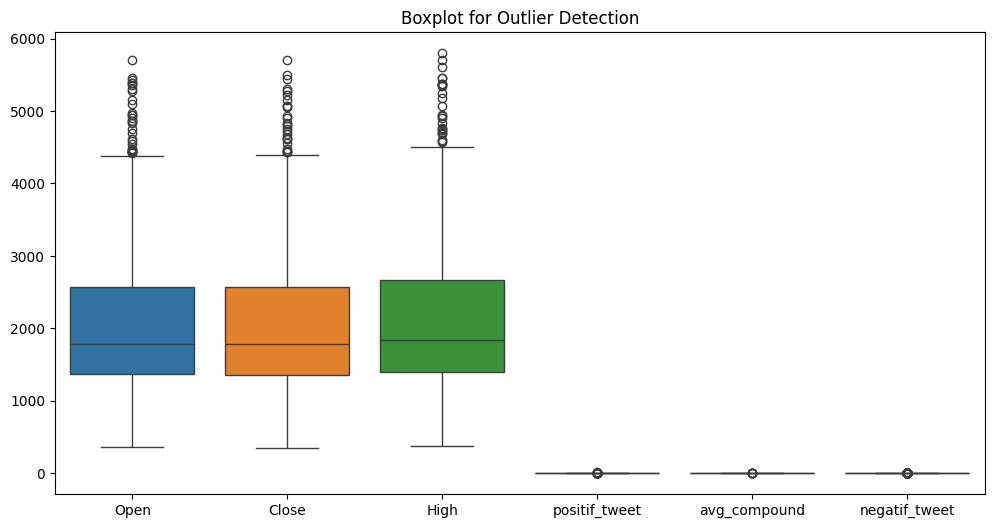

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Open','Close','High','positif_tweet','avg_compound','negatif_tweet']])
plt.title("Boxplot for Outlier Detection")
plt.show()

In [ ]:
# Penanganan outlier dengan trasformasi data
df['Open_log'] = np.log1p(df['Open'])
df['Close_log'] = np.log1p(df['Close'])
df['High_log'] = np.log1p(df['High'])

In [ ]:
from scipy.stats.mstats import winsorize
df['avg_compound_win'] = winsorize(df['avg_compound'], limits=[0.05, 0.05])
df['positif_tweet_win'] = winsorize(df['positif_tweet'], limits=[0.0, 0.10])
df['negatif_tweet_win'] = winsorize(df['negatif_tweet'], limits=[0.0, 0.05])

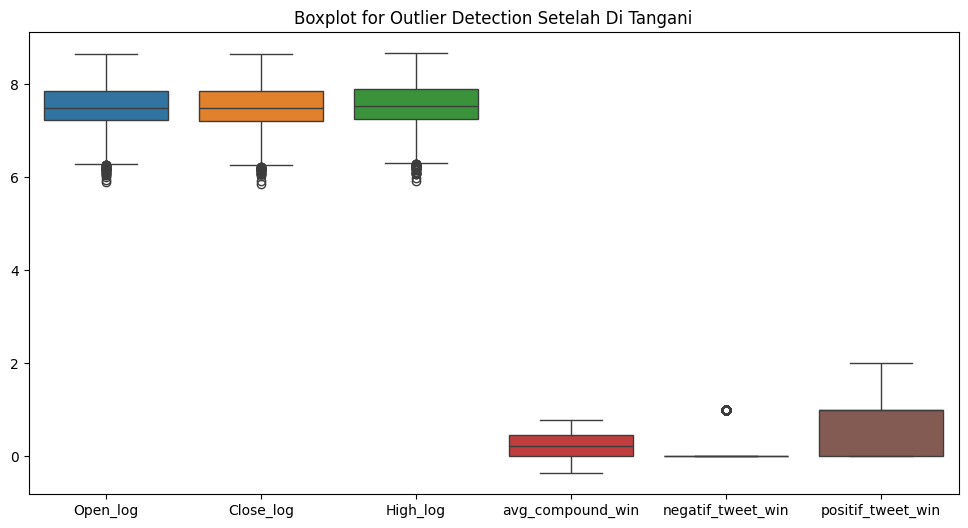

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Open_log','Close_log','High_log','avg_compound_win','negatif_tweet_win','positif_tweet_win']])
plt.title("Boxplot for Outlier Detection Setelah Di Tangani")
plt.show()

In [ ]:
# 4b. Cek Konsistensi Harga 📌
invalid_close = df[df['Close'] < 0]
if not invalid_close.empty:
    print("Data dengan Close < 0 ditemukan:")
    print(invalid_close)
else:
    print("✅ Tidak ditemukan data dengan Close < 0")

✅ Tidak ditemukan data dengan Close < 0


In [ ]:
unreasonable_jump = df.copy()
unreasonable_jump['prev_close'] = unreasonable_jump.groupby('Ticker')['Close'].shift(1)
unreasonable_jump['pct_change'] = (unreasonable_jump['Close'] - unreasonable_jump['prev_close']) / unreasonable_jump['prev_close'] * 100
outliers = unreasonable_jump[np.abs(unreasonable_jump['pct_change']) > 1000]
if not outliers.empty:
    print("Data dengan lonjakan Close > 1000% ditemukan:")
    print(outliers)
else:
    print("✅ Tidak ditemukan lonjakan harga > 1000%")

✅ Tidak ditemukan lonjakan harga > 1000%


In [ ]:
inconsistent_ohlc = df[(df['Close'] > df['High']) | (df['Close'] < df['Low'])]
if not inconsistent_ohlc.empty:
    print("Data Close tidak konsisten dengan High/Low:")
    print(inconsistent_ohlc)

In [ ]:
TICKERS = df['Ticker'].unique()

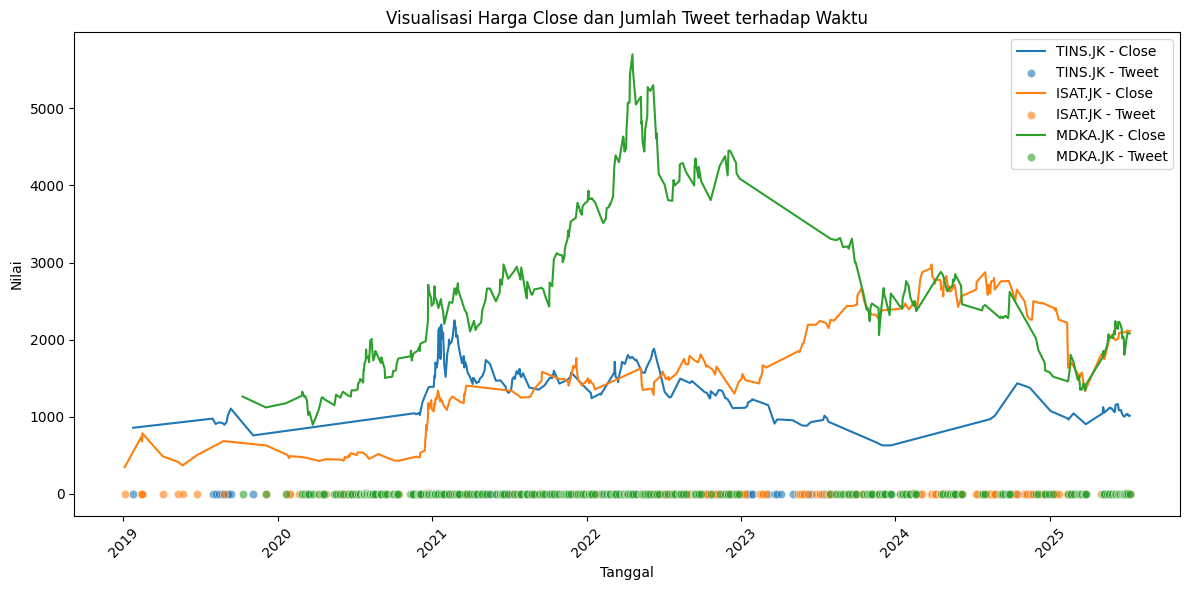

In [ ]:
# Visualisasi ekstrem harga vs total tweet
plt.figure(figsize=(12,6))
for ticker in TICKERS:
    subset = df[df['Ticker'] == ticker]
    sns.lineplot(x='Date', y='Close', data=subset, label=f"{ticker} - Close")
    sns.scatterplot(x='Date', y='total_tweet', data=subset, label=f"{ticker} - Tweet", marker='o', alpha=0.6)
plt.title("Visualisasi Harga Close dan Jumlah Tweet terhadap Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(df.isnull().sum())

Date                 0
Ticker               0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
total_tweet          0
positif_tweet        0
negatif_tweet        0
netral_tweet         0
avg_compound         0
Year                 0
YearMonth            0
Open_log             0
Close_log            0
High_log             0
avg_compound_win     0
positif_tweet_win    0
negatif_tweet_win    0
dtype: int64


In [ ]:
#df.set_index('Date', inplace=True)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df = df.dropna()  # or use imputer if needed

# Feature enginerring

In [ ]:
# Urutkan berdasarkan Ticker dan Date
df = df.sort_values(['Ticker', 'Date'])

# Tambahkan fitur lag dan rolling hanya berdasarkan grup saham
df['Close_lag1'] = df.groupby('Ticker')['Close_log'].shift(1)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# 5. Simpan ke file CSV
df.to_csv("saham_with_lag1.csv", index=False)

In [ ]:
df_lag = pd.read_csv("saham_with_lag1.csv")

# Perancangan model


In [ ]:
# Pilih fitur dan target
feature_cols = ['Open_log', 'High_log','negatif_tweet','Close_lag1']
target_col = 'Close_log'

# Ambil data 1 ticker misal TINS.JK
data = df_lag[df_lag['Ticker'] == 'MDKA.JK'].copy()
data['Date'] = pd.to_datetime(data['Date'])  # pastikan format datetime
data = data.sort_values('Date')              # ✅ JANGAN reset_index
data.set_index('Date', inplace=True)         # ✅ JANGAN ubah posisi ini

# Hapus baris yang menyebabkan NaN
data = data.dropna(subset=feature_cols + [target_col])

X = data[feature_cols].values
y = data[target_col].values
dates = data.index  # sudah aman

In [ ]:
print("Jumlah data asli:", len(X))

Jumlah data asli: 327


In [ ]:
print(len(X), len(y), len(dates))  # semua harus sama


327 327 327


In [ ]:
# GUNAKAN DATA YANG SUDAH DIFILTER TICKER
data = df_lag[df_lag['Ticker'] == 'MDKA.JK'].copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# Hapus NaN kalau ada dari fitur atau target
data = data.dropna(subset=feature_cols + [target_col])
# Hitung jumlah total
n_total = len(data)
n_test = int(n_total * 0.15)
n_val = int(n_total * 0.15)
n_train = n_total - n_test - n_val

# Bagi data
train_data = data.iloc[:n_train]
val_data   = data.iloc[n_train:n_train+n_val]
test_data  = data.iloc[n_train+n_val:]

# Pisahkan X, y, date per bagian
X_train = train_data[feature_cols].values
y_train = train_data[target_col].values
dates_train = train_data['Date']

X_val = val_data[feature_cols].values
y_val = val_data[target_col].values
dates_val = val_data['Date']

X_test = test_data[feature_cols].values
y_test = test_data[target_col].values
dates_test = test_data['Date']


In [ ]:
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 229, Validation: 49, Test: 49


In [ ]:
print(f"Tanggal Train: {dates_train.min()} -> {dates_train.max()}")
print(f"Tanggal Val  : {dates_val.min()} -> {dates_val.max()}")
print(f"Tanggal Test : {dates_test.min()} -> {dates_test.max()}")

Tanggal Train: 2019-12-04 00:00:00 -> 2023-09-12 00:00:00
Tanggal Val  : 2023-09-20 00:00:00 -> 2024-09-17 00:00:00
Tanggal Test : 2024-09-23 00:00:00 -> 2025-07-08 00:00:00


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [ ]:
# ✅ Simpan scaler ke file
import joblib
joblib.dump(scaler_X, 'X_scaler.pkl')
joblib.dump(scaler_y, 'y_scaler.pkl')

['y_scaler.pkl']

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1,2,3],
    'learning_rate': [0.01,0.04,],
    'n_estimators': [50,60,70],
    'subsample': [0.6,0.7,0.8],
    'colsample_bytree': [0.5,0.6,0.8],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1]
}


# Inisialisasi model
model = XGBRegressor( random_state=42)

#Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)


# Latih model
grid_search.fit(X_train_scaled, y_train_scaled.ravel())   # ravel agar shape cocok

# Lihat hasil terbaik
print("Best params:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

# Simpan model terbaik
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 70, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best score (MSE): 0.027028953059593363


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=3)

scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')

print("MSE di tiap fold:", -scores)
print("Rata-rata MSE:", -scores.mean())

MSE di tiap fold: [0.06016718 0.02468452 0.00201334]
Rata-rata MSE: 0.028955012671385432


In [ ]:
from sklearn.metrics import mean_squared_error
print("Train MSE:", mean_squared_error(y_train, best_model.predict(X_train)))
print("Test MSE:", mean_squared_error(y_test, best_model.predict(X_test)))


Train MSE: 48.82792348442589
Test MSE: 43.788862257297225


In [ ]:
# Prediksi test set
y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse scaling dari log-nya
y_test_log = scaler_y.inverse_transform(y_test_scaled)
y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Inverse log ke bentuk harga rupiah
y_test_actual = np.exp(y_test_log)
y_pred = np.exp(y_pred_log)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi di masing-masing split
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Inverse jika target di-scaling
y_train_actual = np.exp(scaler_y.inverse_transform(y_train_scaled))
y_train_pred = np.exp(scaler_y.inverse_transform(y_train_pred.reshape(-1,1)))

y_val_actual = np.exp(scaler_y.inverse_transform(y_val_scaled))
y_val_pred = np.exp(scaler_y.inverse_transform(y_val_pred.reshape(-1,1)))

y_test_actual = np.exp(scaler_y.inverse_transform(y_test_scaled))
y_test_pred = np.exp(scaler_y.inverse_transform(y_test_pred.reshape(-1,1)))


# Hitung metrik
def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    return r2

train_r2 = evaluate(y_train_actual, y_train_pred, "Train")
val_r2 = evaluate(y_val_actual, y_val_pred, "Validation")
test_r2 = evaluate(y_test_actual, y_test_pred, "Test")


if train_r2 > 0.9 and val_r2 < 0.6:
    print("Model kemungkinan overfitting terhadap data training")

Train RMSE: 140.23, MAE: 91.92, R2: 0.99
Validation RMSE: 90.44, MAE: 66.66, R2: 0.85
Test RMSE: 82.88, MAE: 66.58, R2: 0.93


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2 * 100:.2f}%")

MSE: 6868.41
RMSE: 82.88
MAE: 66.58
R² Score: 93.15%


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Scale the full data using the previously fitted scalers
X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y.reshape(-1, 1))

scores = cross_val_score(model, X_scaled, y_scaled.ravel(), cv=3, scoring='r2')
print("R2 CV mean:", np.mean(scores))

R2 CV mean: 0.8984225993247


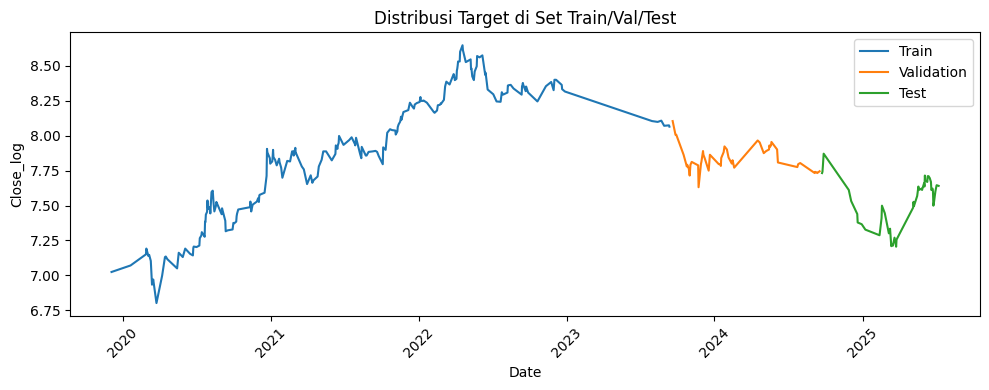

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(dates_train, y_train, label='Train')
plt.plot(dates_val, y_val, label='Validation')
plt.plot(dates_test, y_test, label='Test')

plt.xlabel('Date')
plt.ylabel('Close_log')
plt.title('Distribusi Target di Set Train/Val/Test')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

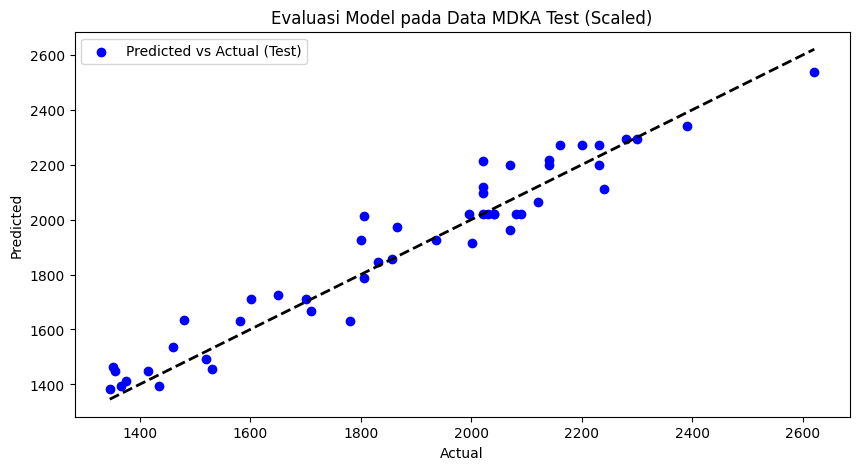

In [ ]:
import matplotlib.pyplot as plt

# 9. Visualisasi scatter plot
plt.figure(figsize=(10,5))
plt.scatter(y_test_actual, y_pred, color='blue', label='Predicted vs Actual (Test)')
plt.plot([min(y_test_actual.min(), y_pred.min()), max(y_test_actual.max(), y_pred.max())],
         [min(y_test_actual.min(), y_pred.min()), max(y_test_actual.max(), y_pred.max())],
         'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Evaluasi Model pada Data MDKA Test (Scaled)")
plt.legend()
plt.show()


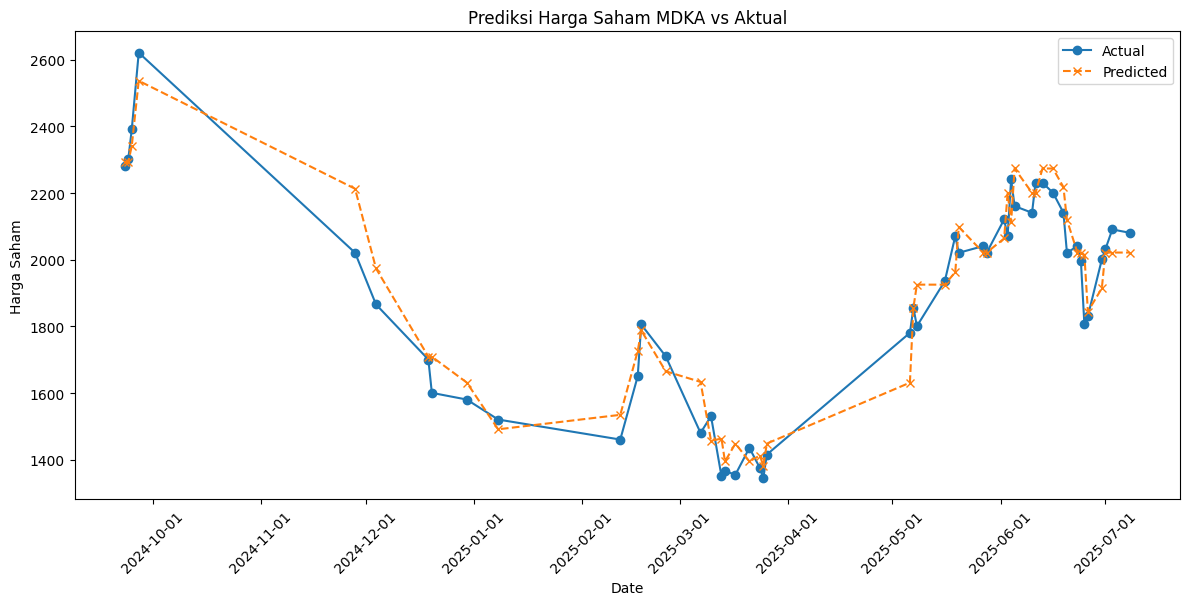

In [ ]:
# Ambil kembali tanggal untuk test set
# dates_test = X_test.index

# Visualisasi hasil prediksi vs aktual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_actual, label='Actual', marker='o')
plt.plot(dates_test, y_pred, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Harga Saham')
plt.title('Prediksi Harga Saham MDKA vs Aktual')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Simpan ke Google Drive
import joblib
joblib.dump(best_model, "isat_model4.pkl")

['isat_model4.pkl']

In [ ]:
print(f"{ticker}: model type = {type(best_model)}")


MDKA.JK: model type = <class 'xgboost.sklearn.XGBRegressor'>
